In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

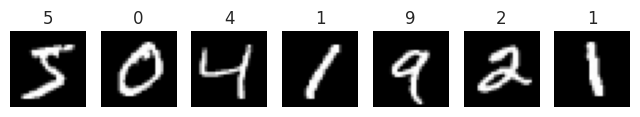

In [2]:
DATA_DIR = '../data'

# Download the datasets

train_dataset = datasets.MNIST(
    root=DATA_DIR,
    download=True,
    train=True,
    transform=ToTensor(),
)

test_dataset = datasets.MNIST( 
    root=DATA_DIR,
    download=True,
    train=False,
    transform=ToTensor(),
)

batch_size = 64 

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Visualize the dataset
fig, ax = plt.subplots(1, 7)
for i in range(7):
    ax[i].imshow(train_dataset[i][0].squeeze(), cmap='gray')
    ax[i].set_title(train_dataset[i][1])
    ax[i].axis('off')


In [3]:
# Define the model

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        y = self.linear_relu_stack(x)
        return y


def train(model, dataloader, loss_fn, optimizer):
    model.train()
    total_loss, total_acc, count = 0, 0, 0

    for x_train, y_train in train_dataloader:
        y_pred = model(x_train)

        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred = torch.max(y_pred, 1)[1]
        total_acc += (pred == y_train).sum()
        total_loss += loss
        count += len(y_train)

    return total_loss.item()/count, total_acc.item()/count


def validate(model, dataloader, loss_fn):
    total_loss, total_acc, count = 0, 0, 0
    model.eval()

    with torch.no_grad():
        for x_val, y_val in dataloader:
            y_pred = model(x_val)
            loss = loss_fn(y_pred, y_val)

            pred = torch.max(y_pred, 1)[1]
            total_acc += (pred == y_val).sum()
            total_loss += loss
            count += len(y_val)

    return total_loss.item()/count, total_acc.item()/count


In [4]:
learning_rate = 0.01 

model = Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

history = {
    'train_loss': [], 
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}
epochs = 25

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_dataloader, loss_fn, optimizer)
    val_loss, val_acc = validate(model, test_dataloader, loss_fn)

    history['train_loss'] += [train_loss]
    history['train_acc'] += [train_acc]
    history['val_loss'] += [val_loss]
    history['val_acc'] += [val_acc]

    if epoch % 5 == 0:
        print(
            f'Epoch {epoch+1:2}: train_acc = {train_acc:.3f}, train_loss = {train_loss:.3f}, '
            f'val_acc = {val_acc:.3f}, val_loss = {val_loss:.3f}'
        )

Epoch  1: train_acc = 0.739, train_loss = 0.019, val_acc = 0.862, val_loss = 0.009
Epoch  6: train_acc = 0.912, train_loss = 0.005, val_acc = 0.917, val_loss = 0.005
Epoch 11: train_acc = 0.928, train_loss = 0.004, val_acc = 0.931, val_loss = 0.004
Epoch 16: train_acc = 0.940, train_loss = 0.003, val_acc = 0.940, val_loss = 0.003
Epoch 21: train_acc = 0.948, train_loss = 0.003, val_acc = 0.947, val_loss = 0.003


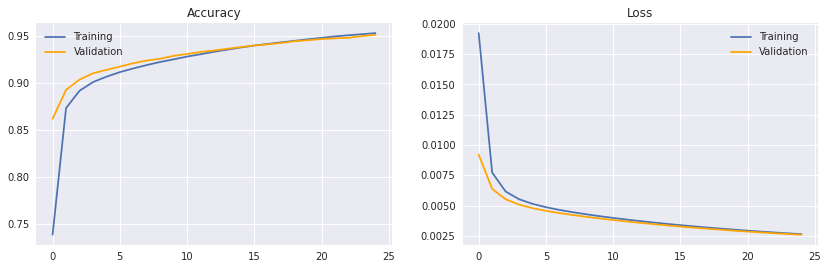

Bad pipe message: %s [b'N\x9ad\\\x95N*%\xb8r9;\x03*\x0e\xcb\r\xe8 K\x9c\xe0\x98\n\xc7\xa0O|\xd2\x8ah)\x1a\xb6z\x08\x8ap\xcc\xa24\xa2\x9a\xf3xkD\r\x85,\xab\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06', b'\x07\x08']
Bad pipe message: %s [b'\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b'\x08\x06\x04\x01\x05\x01\x06', b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 <\xb1;nE\t\x1e\xa3\x87\x84I^\xdb1\xa5\xef;\xf7@\xf9Vi']
Bad pipe message: %s [b"w\x0c\xa2AK\xdano\xaae\x92\xf2\xc6r\x8f%\xcbQ\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x

In [6]:
plt.figure(figsize=(14,4), dpi=72)
plt.subplot(121)
plt.plot(history['train_acc'], label='Training')
plt.plot(history['val_acc'], label='Validation', color='orange')
plt.title('Accuracy')
plt.legend()
plt.subplot(122)
plt.plot(history['train_loss'], label='Training')
plt.plot(history['val_loss'], label='Validation', color='orange')
plt.title('Loss')
plt.legend()